In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

## Data upload
We start by uploading the Ames housing data, containing the sale price of various houses sold in Iowa with their characteristics. Our goal is to predict a house sale price, based on the property's features (e.g. neighbourhood, size, types of roofs, pools etc.). 

We will parse it to Pandas DataFrame structure for easier analysis. The funtion head() returns the first five rows of the DataFrame, convenient for inspecting how the data looks. Data is already split into train and test sets. info() tells us we are working with 1460 train entries and 1459 test entries and gives all the stored data types.

In [2]:
da=pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
dftrain=pd.DataFrame(da)
print(dftrain.info())
dftrain.head()
dftrain.set_index('Id', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [3]:
db=pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
dftest=pd.DataFrame(db)
#print(dftest.info())
print(dftest.shape)
dftest.set_index('Id', inplace=True)
dftest.head()

(1459, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


There are 79 features based on which we should make our sale price assumption. Every entry (property) has a unique Id and the train set contains sale prices. This gives a total of 81 columns, whereas the test data does not contain sale prices which totals to one less - 80 columns. 

## Exploring the data

Before reshaping the data for machine learning models, we explore different features and their distributions to better understand how they affect the value of interest - sale price. Simple visualizations can give us a first impression about cleanliness of our data and the share of outliers, missing values and similar. 

Distribution plot of Sale price shows to be right-winged. This was expected as property prices tend to be skewed to the right with some houses reaching very high values:

C:\Users\Bubo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


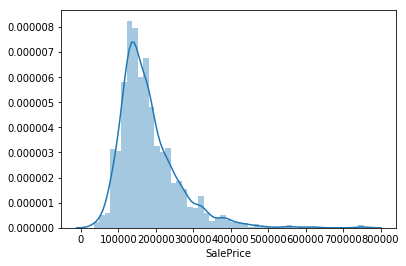

In [4]:
sns.distplot(dftrain['SalePrice'])

To better work with some models, the target should be transformed into a normal distribution. Right-wing distributions can easily be transformed to normal by using a log-scale or implementing a Box-Cox transformation, for example. 

#### Log transform:

C:\Users\Bubo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


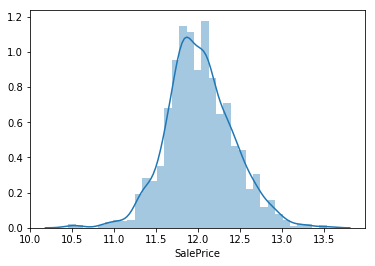

In [5]:
sns.distplot(np.log(dftrain['SalePrice']))

#### Box-cox transform:

C:\Users\Bubo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


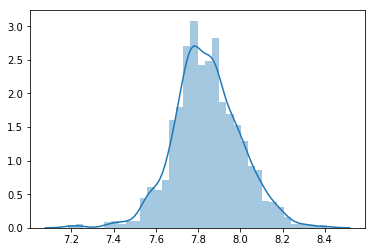

In [6]:
transform = np.asarray(dftrain[['SalePrice']].values)
trn, lmbd = sp.stats.boxcox(transform)

sns.distplot(trn)

We will use whichever transformation gives a larger p-value in normality test:

In [7]:
pvlog=sp.stats.normaltest(np.log(dftrain['SalePrice']))[1]
pvbox=sp.stats.normaltest(trn)[1][0]
if(pvlog>pvbox):
    print("Log-scale transformation gives a result with higher normality")
else:
    print("Box-cox transformation gives a result with higher normality")

Box-cox transformation gives a result with higher normality


In [8]:
dftrain['SalePrice']=trn
dftrain['SalePrice'].skew()

-0.00865297992364803

When reshaping, it will be more convenient to work with a joint DataFrame, containing both train and test entries. For the purpose of the two DataFrames remaining intact and available for later use, we build a new DataFrame by merging them:

In [9]:
df=pd.concat([dftrain,dftest], sort=False)
df.shape

(2919, 80)

Let's explore the types of data we have. Some attributes will be of numerical nature, and some will be qualitative. Sometimes quantitative values are qualitative in nature, for example when different shapes are marked with numbers. We should also pay attention to values that are not ordinal in nature. All the attributes are described in the given txt file.

In [10]:
df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


Looking at the distribution of _MSSubClass_ we see it only takes discrete values. These values represent different types of dwelling. Therefore, this value is categorical in nature, but only represented through numbers. 

C:\Users\Bubo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


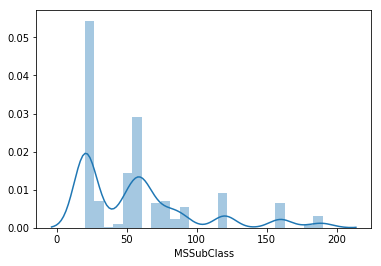

In [11]:
sns.distplot(df['MSSubClass'])

Later, we will deal with all attributes of this type with one hot encoding. For now let's look at mising values.

#### Missing data

<BarContainer object of 34 artists>

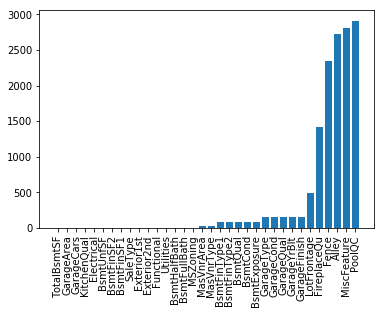

In [12]:
missval=df.drop(['SalePrice'], axis=1).isnull().sum().drop(df.isnull().sum()[df.isnull().sum() == 0].index).sort_values()
plt.xticks(rotation="90")
plt.bar(missval.index, missval)

Some attributes have a high abundance of missing values. Mostly those are _LotFrontage, FireplaceQu, Fence, Alley, MiscFeature_ and _PoolQC_. We'll inspect them one by one.

In [13]:
missval[missval>400]

LotFrontage     486
FireplaceQu    1420
Fence          2348
Alley          2721
MiscFeature    2814
PoolQC         2909
dtype: int64

According to the documentation, _FireplaceQu_ and _PoolQC_ are qualities represented by 
       Ex:	Excellent, 
       Gd:	Good, 
       TA:	Average, 
       Fa:	Fair, 
       Po:	Poor, 
       NA:	No Fireplace/Pool.
Therefore, missing values can be filled with 'None'.


In [14]:
df['FireplaceQu'].fillna('None', inplace=True)
df['PoolQC'].fillna('None', inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,None,NaN,NaN,0,2,2008,WD,Normal,7.932608
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,None,NaN,NaN,0,5,2007,WD,Normal,7.878261
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,None,NaN,NaN,0,9,2008,WD,Normal,7.959616
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,None,NaN,NaN,0,2,2006,WD,Abnorml,7.774953
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,None,NaN,NaN,0,12,2008,WD,Normal,8.002873


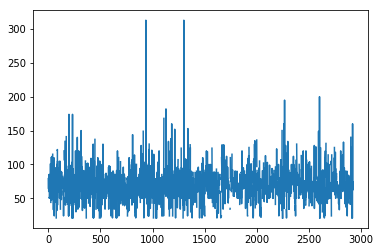

In [15]:
plt.plot(df['LotFrontage'])

_LotFrontage_ describes the distance from the street to the entrance. We can fill by looking how other LotFrontages distribute in different neighbourhoods, as they tend to be similar inside them.


In [16]:
df['LotFrontage']=df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

Two outliers are visible as they have a higher _LotFrontage_ than other entries. We will drop them in the next section.

This leaves us with _Fence, Alley_ and _MiscFeature_.

_Fence_ describes quality, although marked with different values than _FireplaceQu_ and _PoolQC_. The documentation states that missing values in _Alley_ and _MiscFeatures_ also represent the absence of those. We will handle it in the same manner:

In [17]:
df['Fence'].fillna('None', inplace=True)
df['Alley'].fillna('None', inplace=True)
df['MiscFeature'].fillna('None', inplace=True)

We can now look again how missing values are distributed across the data:

<BarContainer object of 28 artists>

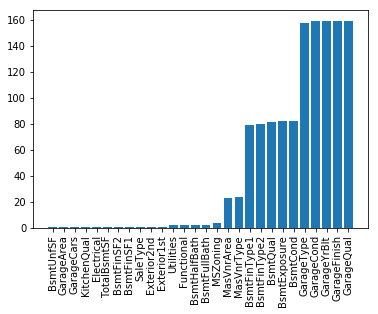

In [18]:
missval=df.drop(['SalePrice'], axis=1).isnull().sum().drop(df.isnull().sum()[df.isnull().sum() == 0].index).sort_values()
plt.xticks(rotation="90")
plt.bar(missval.index, missval)

In [19]:
missval[missval>0]

BsmtUnfSF         1
GarageArea        1
GarageCars        1
KitchenQual       1
Electrical        1
TotalBsmtSF       1
BsmtFinSF2        1
BsmtFinSF1        1
SaleType          1
Exterior2nd       1
Exterior1st       1
Utilities         2
Functional        2
BsmtHalfBath      2
BsmtFullBath      2
MSZoning          4
MasVnrArea       23
MasVnrType       24
BsmtFinType1     79
BsmtFinType2     80
BsmtQual         81
BsmtExposure     82
BsmtCond         82
GarageType      157
GarageCond      159
GarageYrBlt     159
GarageFinish    159
GarageQual      159
dtype: int64

Where Masonry veneer type is null, i.e. Masonry veneer is nonexistent at that house, it's area should also be 0. We have one entry that has a positive area but a null type. We will handle it by assigning 0 area to all nonexistent masonry veneers.

In [20]:
df[df['MasVnrType'].isnull()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN
1692,NaN,NaN


In [21]:
df[df['MasVnrType'].isnull()][['MasVnrArea']].replace(198,0)
df['MasVnrType'].fillna('None', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

All attributes starting with Bsmt refer to the property's basement. Since there are  82 missing values for Basement condition and exposure we can safely assume 82 properties dont have a basement:

In [22]:
df['BsmtCond'].fillna('None', inplace=True)
df['BsmtFinType2'].fillna('None', inplace=True)
df['BsmtQual'].fillna('None', inplace=True)
df['BsmtExposure'].fillna('None', inplace=True)
df['BsmtFinType1'].fillna('None', inplace=True)
df['BsmtFinSF1'].fillna(0, inplace=True)
df['BsmtFinSF2'].fillna(0, inplace=True)
df['BsmtHalfBath'].fillna(0, inplace=True)
df['BsmtFullBath'].fillna(0, inplace=True)

This can be applied to all the attributes regarding the garage, aswell.

In [23]:
df['GarageType'].fillna('None', inplace=True)
df['GarageFinish'].fillna('None', inplace=True)
df['GarageQual'].fillna('None', inplace=True)
df['GarageCond'].fillna('None', inplace=True)
df['GarageArea'].fillna(0, inplace=True)
df['GarageCars'].fillna(0, inplace=True)
df['GarageYrBlt'].fillna(0, inplace=True)

In [24]:
missval=df.drop(['SalePrice'], axis=1).isnull().sum().drop(df.isnull().sum()[df.isnull().sum() == 0].index).sort_values()
missval

Exterior1st    1
Exterior2nd    1
BsmtUnfSF      1
TotalBsmtSF    1
Electrical     1
KitchenQual    1
SaleType       1
Utilities      2
Functional     2
MSZoning       4
dtype: int64

_MSzoning_, _Functional_, _Utilities_, _SaleType_, _KitchenQual_ and _Electrical_ can be filled with their most common value. Presence of different values can be inspected either using the method unique() or groupby(). The remaining basement attributes should also be set to 0.

In [25]:
df.groupby(['MSZoning']).count()
df.groupby(['Functional']).count()
df.groupby(['Utilities']).count()
df.groupby(['KitchenQual']).count()
df.groupby(['Electrical']).count()

df.groupby(['TotalBsmtSF']).count()
df.groupby(['BsmtUnfSF']).count()

df.groupby(['Exterior1st']).count()
df.groupby(['Exterior2nd']).count()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Exterior2nd,,,,,,,,,,,,,,,,,,,,,
AsbShng,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,20
AsphShn,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,3
Brk Cmn,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,7
BrkFace,47,47,47,47,47,47,47,47,46,47,...,47,47,47,47,47,47,47,47,47,25
CBlock,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,1
CmentBd,126,126,126,126,126,126,126,126,126,126,...,126,126,126,126,126,126,126,126,126,60
HdBoard,406,406,406,406,406,406,406,406,406,406,...,406,406,406,406,406,406,406,406,406,207
ImStucc,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,10
MetalSd,447,447,447,447,447,447,447,447,447,447,...,447,447,447,447,447,447,447,447,447,214


In [26]:
df['Exterior1st'].fillna(df['Exterior1st'].mode()[0], inplace=True)
df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0], inplace=True)
df['MSZoning'].fillna(df['MSZoning'].mode()[0], inplace=True)
df['Utilities'].fillna(df['Utilities'].mode()[0], inplace=True)
df['KitchenQual'].fillna(df['KitchenQual'].mode()[0], inplace=True)
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
df['SaleType'].fillna(df['SaleType'].mode()[0], inplace=True)
df['Functional'].fillna(df['Functional'].mode()[0], inplace=True)

df['TotalBsmtSF'].fillna(0, inplace=True)
df['BsmtUnfSF'].fillna(0, inplace=True)


missval=df.drop(['SalePrice'], axis=1).isnull().sum().drop(df.isnull().sum()[df.isnull().sum() == 0].index).sort_values()
missval

Series([], dtype: int64)

There are no remaining missing values in attributes.

Before feature engineering, we should decide if we're going to introduce new variables to the dataset. For example, porch area is split in different attributes so we can add them to find the total. In the same manner we will find the total living and bathroom area.

In [27]:
df['TotPorcharea']=df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch']
df['Totlivarea']=df['TotalBsmtSF']+df['GrLivArea']+df['GarageArea']
df['TotalBth'] = (df['FullBath']+(0.5*df['HalfBath'])+df['BsmtFullBath']+(0.5*df['BsmtHalfBath']))

#### Correlation and outliers

Plotting different attributes over Sale Price can help us determine if there are wrong entries that can badly influence our models. When inspecting these, the results should be sensical. For example, we expect the price to rise with the property's quality and area. There are some properties with very large lot areas, but they also have high prices, which is sensical. We therefore dont have to delete them. 


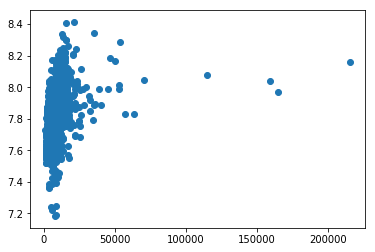

In [28]:
plt.scatter(df['LotArea'], df['SalePrice'])

In [29]:
df=df.drop(df[df['LotArea']>100000].index)

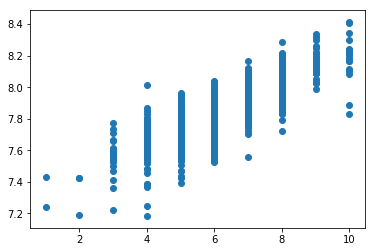

In [30]:
plt.scatter(df['OverallQual'], df['SalePrice'])

Looking at the _OverallCond_ which is a score of the property's condition, we can spot a property with a very low score and a high price. We will drop this entry as an outlier.

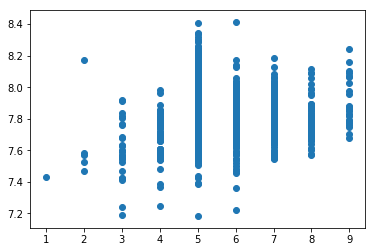

In [31]:
plt.scatter(df['OverallCond'], df['SalePrice'])

In [32]:
df[(df['SalePrice']>8) & (df['OverallCond']<3)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotPorcharea,Totlivarea,TotalBth
Id,,,,,,,,,,,,,,,,,,,,,
379,20,RL,88.0,11394,Pave,None,Reg,Lvl,AllPub,Corner,...,None,0,6,2010,New,Partial,8.175109,0,4546.0,2.5


In [33]:
df=df.drop(df[(df['SalePrice']>8) & (df['OverallCond']<3)].index) 

We can also see two very large properties with a relatively medium price by plotting. We will drop them aswell:

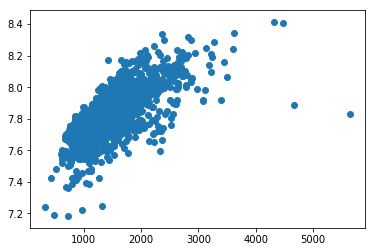

In [34]:
plt.scatter(df['GrLivArea'], df['SalePrice'])

In [35]:
df=df.drop(df[(df['SalePrice']<8) & (df['GrLivArea']>4000)].index) 

Area of the finished basement part has an apparent trend except for an outliers that seems to have a too large value for _BsmtFinSF2_ while holding a medium price. 

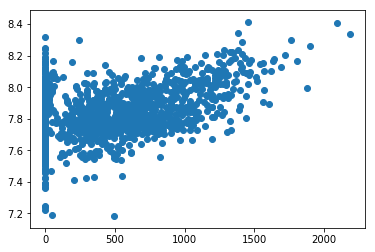

In [36]:
plt.scatter(df['BsmtFinSF1'], df['SalePrice'])

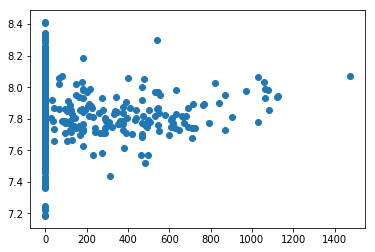

In [37]:
plt.scatter(df['BsmtFinSF2'], df['SalePrice'])

In [38]:
df=df.drop(df[(df['SalePrice']>8) & (df['BsmtFinSF2']>1400)].index)

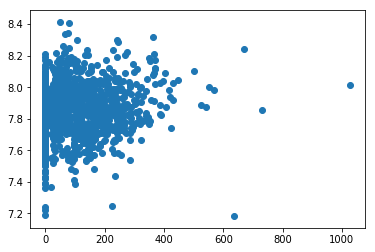

In [39]:
plt.scatter(df['TotPorcharea'], df['SalePrice'])

In [40]:
df=df.drop(df[(df['TotPorcharea']>600) & (df['SalePrice']>0)].index)

Distribution of _SalePrice_ over _Totlivarea_ seems fair and no outliers are dropped. The total number of bathrooms aswell (the point that seems as an outlier on the _TotalBth_ plot comes from the fact that only one property contains 6 bathroom, but this does not make it an outlier). 

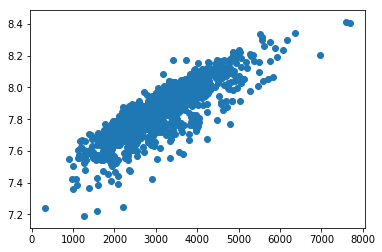

In [41]:
plt.scatter(df['Totlivarea'], df['SalePrice'])

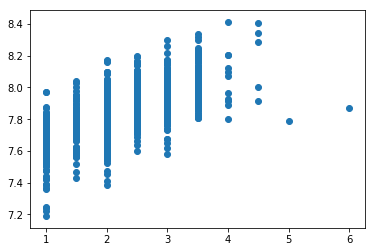

In [42]:
plt.scatter(df['TotalBth'], df['SalePrice'])

Most categorical attributes don't have an apparent relationship with _SalePrice_, but some outliers can be seen. _Condition1_ and _Condition2_ have a very low presence of values different than _Normal_ but as we don't know how it affects the price we will not change them. There is only one property with _Utilities_ _'NoSeWa'_, we can replace it with the common value.

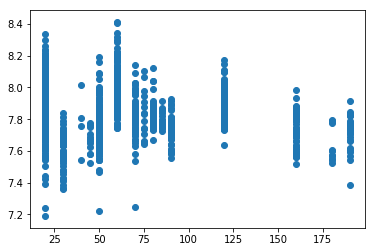

In [43]:
plt.scatter(df['MSSubClass'], df['SalePrice'])

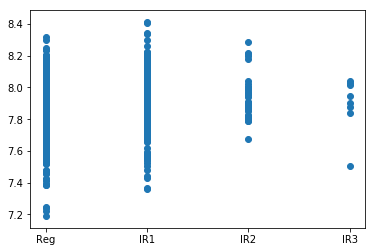

In [44]:
plt.scatter(df['LotShape'], df['SalePrice'])

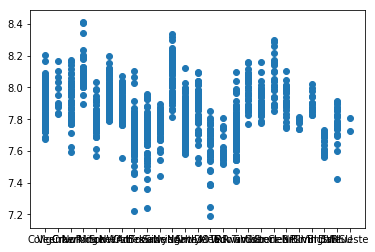

In [45]:
plt.scatter(df['Neighborhood'], df['SalePrice'])

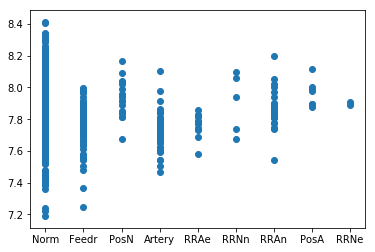

In [46]:
plt.scatter(df['Condition1'], df['SalePrice'])

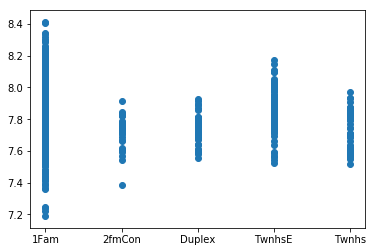

In [47]:
plt.scatter(df['BldgType'], df['SalePrice'])

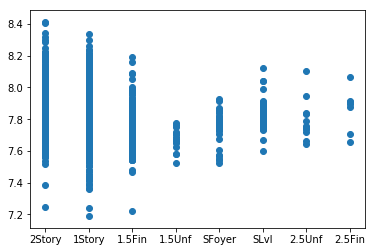

In [48]:
plt.scatter(df['HouseStyle'], df['SalePrice'])

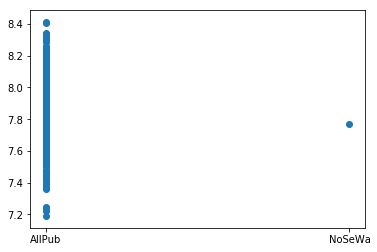

In [49]:
plt.scatter(df['Utilities'], df['SalePrice'])

In [50]:
df[df['Utilities']=='NoSeWa']=df[df['Utilities']=='NoSeWa'].replace('NoSeWa','AllPub')

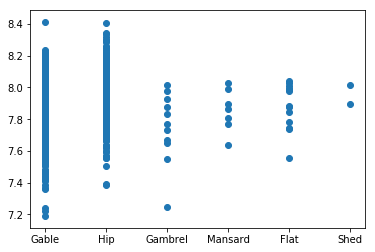

In [51]:
plt.scatter(df['RoofStyle'], df['SalePrice'])

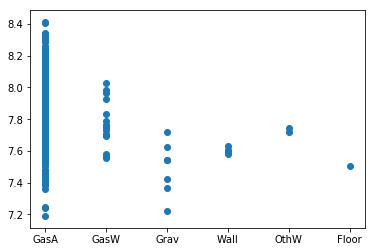

In [52]:
plt.scatter(df['Heating'], df['SalePrice'])

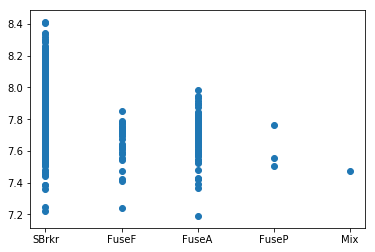

In [53]:
plt.scatter(df['Electrical'], df['SalePrice'])

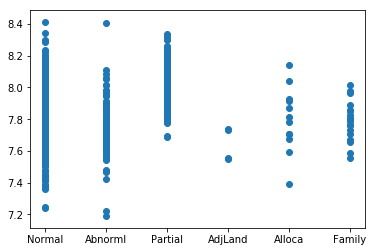

In [54]:
plt.scatter(df['SaleCondition'], df['SalePrice'])

As we already mentioned, we will drop two outliers by _LotFrontage_:

In [55]:
df=df.drop(df[df['LotFrontage']>200].index)

Correlation matrix gives us a value between all pairs in the dataframe. We are mostly interested in correlations with _SalePrice_:

In [56]:
contincorrel=df.corr()
contincorrel.style.background_gradient(cmap='Oranges').set_precision(3)

In [57]:
contincorrel[abs(contincorrel['SalePrice'])>0.5]['SalePrice']

OverallQual     0.821296
YearBuilt       0.599713
YearRemodAdd    0.570986
TotalBsmtSF     0.645093
1stFlrSF        0.613510
GrLivArea       0.719102
FullBath        0.597475
TotRmsAbvGrd    0.531443
GarageCars      0.678897
GarageArea      0.652936
SalePrice       1.000000
Totlivarea      0.847520
TotalBth        0.676419
Name: SalePrice, dtype: float64

#### Casting categories to ordinal values

As previously stated, some categorical attributes can be numerical in nature or vice versa. For example, the shape of the property's land is expressed by a _str_ in the dataset but we can arbitrary add an _int_ value to them. When assigning numbers, we try to assign higher score to better attributes e.g. less slope, more utilities, better condition etc. Quality is also ordinal in nature. We can assign a scale to these categories, with higher numbers representing higher quality. _HouseStyle_ represents the number of floors in the property, again convenient for parsing to numbers. _Functionality_ will also be assesed with higher numbers for less damages. After assigning this we can inspect the correlation with _SalePrice_ aswell, as these attributes will now be numerical.

Some attributes have a binary answer (yes/no) (like the existence of paved driveway). These are parsed to 1 for existent and 0 for nonexistent. 

We should be careful because, for example, if we assign a 1 for a low fence quality and a 2 for good fence quality, our models can assume that good fence quality is important twice as much. This doesn't have to be true in reality, but these approximations show better results than one hot encoding for the same attributes.

In [58]:
def shapeScale(x):
    if(x=='Reg'):
        r = 3
    elif(x=='IR1'):
        r = 2
    elif(x=='IR2'):
        r = 1
    elif(x=='IR3'):
        r = 0
    else:
        r = -1
    return r

def slopeScale(x):
    if(x=='Gtl'):
        r = 3
    elif(x=='Mod'):
        r = 2
    elif(x=='Sev'):
        r = 1
    else:
        r = -1
    return r

def flatnessScale(x):
    if(x=='Lvl'):
        r = 3
    elif(x=='Bnk'):
        r = 2
    elif(x=='HLS'):
        r = 1
    elif(x=='Low'):
        r = 0
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def scaleQuality(x):
    if(x=='Ex'):
        r = 5
    elif(x=='Gd'):
        r = 4
    elif(x=='TA'):
        r = 3
    elif(x=='Fa'):
        r = 2
    elif(x=='Po'):
        r = 1
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def fenceQuality(x):
    if(x=='GdPrv'):
        r = 4
    elif(x=='MnPrv'):
        r = 3
    elif(x=='GdWo'):
        r = 2
    elif(x=='MnWw'):
        r = 1
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def basemFinQuality(x):
    if(x=='GLQ'):
        r = 6
    elif(x=='ALQ'):
        r = 5
    elif(x=='BLQ'):
        r = 4
    elif(x=='Rec'):
        r = 3
    elif(x=='LwQ'):
        r = 2
    elif(x=='Unf'):
        r = 1
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def basemExp(x):
    if(x=='Gd'):
        r = 4
    elif(x=='Av'):
        r = 3
    elif(x=='Mn'):
        r = 2
    elif(x=='No'):
        r = 1
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def scaleStyle(x):
    if(x=='1Story'):
        r = 1
    elif(x=='1.5Unf'):
        r = 2
    elif(x=='1.5Fin'):
        r = 3
    elif(x=='2Story'):
        r = 4  
    elif(x=='2.5Unf'):
        r = 5
    elif(x=='2.5Fin'):
        r = 6          
    elif(x=='SLvl'):
        r = 7   
    elif(x=='SFoyer'):
        r = 8
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def electricQuality(x):
    if(x=='SBrkr'):
        r = 4
    elif(x=='FuseA'):
        r = 3
    elif(x=='FuseF'):
        r = 2
    elif(x=='FuseP'):
        r = 1
    elif(x=='Mix'):
        r = 2
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def functQuality(x):
    if(x=='Typ'):
        r = 8
    elif(x=='Sal'):
        r = 7
    elif(x=='Min1'):
        r = 6
    elif(x=='Min2'):
        r = 5
    elif(x=='Mod'):
        r = 4
    elif(x=='Maj1'):
        r = 3
    elif(x=='Maj2'):
        r = 2
    elif(x=='Maj1'):
        r = 1
    elif(x=='Sev'):
        r = 0
    else:
        r = 8  # documentation states to assume Typical if not otherwise instructed
    return r

def drivewayQuality(x):
    if(x=='Y'):
        r = 2
    elif(x=='P'):
        r = 1
    elif(x=='N'):
        r = 0
    else:
        r = 0
    return r

def pavementExist(x):
    if(x=='Pave'):
        r = 1
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def garageFinish(x):
    if(x=='Fin'):
        r = 3
    elif(x=='RFn'):
        r = 2
    elif(x=='Unf'):
        r = 1
    elif(x=='None'):
        r = 0
    else:
        r = -1
    return r

def airCondExist(x):
    if(x=='Y'):
        r = 1
    else:
        r = 0
    return r

def pavedExist(x):
    if(x=='Pave'):
        r = 1
    else:
        r = 0
    return r

In [59]:
df['LotShape'] = df['LotShape'].apply(shapeScale)
df['LandSlope'] = df['LandSlope'].apply(slopeScale)
df['LandContour'] = df['LandContour'].apply(flatnessScale)
df['PoolQC'] = df['PoolQC'].apply(scaleQuality)
df['KitchenQual'] = df['KitchenQual'].apply(scaleQuality)
df['HeatingQC'] = df['HeatingQC'].apply(scaleQuality)
df['ExterQual'] = df['ExterQual'].apply(scaleQuality)
df['ExterCond'] = df['ExterCond'].apply(scaleQuality)
df['FireplaceQu'] = df['FireplaceQu'].apply(scaleQuality)
df['GarageQual'] = df['GarageQual'].apply(scaleQuality)
df['GarageCond'] = df['GarageCond'].apply(scaleQuality)
df['BsmtQual'] = df['BsmtQual'].apply(scaleQuality)
df['BsmtCond'] = df['BsmtCond'].apply(scaleQuality)
df['BsmtFinType1'] = df['BsmtFinType1'].apply(basemFinQuality)
df['BsmtFinType2'] = df['BsmtFinType2'].apply(basemFinQuality)
df['BsmtExposure'] = df['BsmtExposure'].apply(basemExp)
df['Fence'] = df['Fence'].apply(fenceQuality)
df['HouseStyle'] = df['HouseStyle'].apply(scaleStyle)
df['Electrical'] = df['Electrical'].apply(electricQuality)
df['Functional'] = df['Functional'].apply(functQuality)
df['PavedDrive'] = df['PavedDrive'].apply(drivewayQuality)
df['GarageFinish'] = df['GarageFinish'].apply(garageFinish)
df['CentralAir'] = df['CentralAir'].apply(airCondExist)
df['Street'] = df['Street'].apply(pavedExist)
df['Alley'] = df['Alley'].apply(pavedExist)

If there are some different values (errors) or still missing values, they will be marked with -1. A quick check through the DataFrame shows no values are assigned with -1:

In [60]:
df.isin([-1]).any()[df.isin([-1]).any()==True]

Series([], dtype: bool)

_YearBuilt_, _YearRemodAdd_ and _GarageYrBlt_ are years property, remodelation or garage was made and are still left to handle. _MoSold_ and _YrSold_ are month and year of selling. Let's see if they have a high influence to the sale price. 

In [61]:
df[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold', 'SalePrice']].corr().style.background_gradient(cmap='winter').set_precision(3)

,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold,SalePrice
YearBuilt,1,0.613,0.259,0.0154,-0.0137,0.6
YearRemodAdd,0.613,1,0.145,0.0186,0.0341,0.571
GarageYrBlt,0.259,0.145,1,0.0226,-0.00912,0.348
MoSold,0.0154,0.0186,0.0226,1,-0.155,0.0619
YrSold,-0.0137,0.0341,-0.00912,-0.155,1,-0.0355
SalePrice,0.6,0.571,0.348,0.0619,-0.0355,1


Since _MoSold_ and _YrSold_ have an insignificant correlation we will be dropping them completely. 
In contrast, the years of building are highly correlated. This makes sense as newly built properties will have a higher price. 

To assign a higher value to recently built properties, we can take the absolute value of the deduction from the minimal value (oldest year in that particular set).
This way, if different houses were built since 1872, a house built in 1950 will have a score of abs(1872-1950)=78 and a house built in 2005 will have a score of abs(1872-1950)=133. The oldest house, from 1872, will score a 0. 

In [62]:
df['YearRemodAdd'].unique()

array([2003, 1976, 2002, 1970, 2000, 1995, 2005, 1973, 1950, 1965, 2006,
       1962, 2007, 1960, 2001, 1967, 2004, 2008, 1997, 1959, 1990, 1955,
       1983, 1980, 1966, 1963, 1987, 1964, 1972, 1996, 1998, 1989, 1953,
       1956, 1968, 1981, 1992, 2009, 1982, 1961, 1993, 1999, 1985, 1979,
       1977, 1969, 1958, 1991, 1971, 1952, 1975, 2010, 1984, 1986, 1994,
       1988, 1954, 1957, 1951, 1978, 1974], dtype=int64)

In [63]:
minima=1896
def garRec(x):
    if x==0:
        return 0
    elif x>2019:
        return 0
    elif x=='None':
        return 0
    else:
        return abs(minima-x)
df['GarageYrBlt']=df['GarageYrBlt'].apply(garRec)
minima=df['YearRemodAdd'].min()
df['YearRemodAdd']=df['YearRemodAdd'].apply(garRec)
minima=df['YearBuilt'].min()
df['YearBuilt']=df['YearBuilt'].apply(garRec)

In [64]:
df=df.drop(['MoSold', 'YrSold'], axis=1)

Other categorical attributes, like _MSZoning_ that classifies the type of sale, are not ordinal and should be one hot encoded.

#### Skewness

After applying the _scaleQuality_ and other functions we built, ordinal attributes that were represented categoricaly are now represented in numerical scales. Areas of different property's parts (lot area, basement area, first floor area etc.) are given in square feet and are continuous variables. Some other categorical features are also represented in scales now, either discrete or continuous. 

Let's look at how symmetric these distributions are.

In [65]:
areas=['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','TotPorcharea', 'Totlivarea']
scales=['OverallQual', 'OverallCond', 'PoolQC', 'KitchenQual', 'HeatingQC', 'ExterQual', 'ExterCond', 'FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'Functional']
other=['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'MiscVal', 'LotShape', 'LandSlope', 'LandContour', 'BsmtExposure', 'Fence', 'HouseStyle', 'GarageFinish', 'TotalBth']
crkarea = pd.Series(df[areas].apply(lambda x: sp.stats.skew(x.dropna())).sort_values(ascending=False))
crkscl = pd.Series(df[scales].apply(lambda x: sp.stats.skew(x.dropna())).sort_values(ascending=False))
crkoth = pd.Series(df[other].apply(lambda x: sp.stats.skew(x.dropna())).sort_values(ascending=False))

In [66]:
crkarea

PoolArea         17.654963
LowQualFinSF     12.388194
3SsnPorch        11.350139
BsmtFinSF2        4.111093
EnclosedPorch     3.998586
ScreenPorch       3.882609
LotArea           3.611082
MasVnrArea        2.627984
OpenPorchSF       2.396291
TotPorcharea      2.039962
WoodDeckSF        1.837139
1stFlrSF          1.270768
GrLivArea         1.063987
BsmtFinSF1        0.984455
BsmtUnfSF         0.919362
Totlivarea        0.900529
2ndFlrSF          0.859524
TotalBsmtSF       0.676517
LotFrontage       0.629734
GarageArea        0.220853
dtype: float64

Since there are no negative values, no distribution in _crkarea_ has a heavy tail on left side.

We will apply the Box-cox transformation as with the _SalePrice_ on all skewed continuous variables representing areas in square feet (except _GarageArea_ as it is the only one that showed to have a larger skew after transformation):

In [67]:
for column in crkarea.drop('GarageArea').index:
    transform = np.asarray(df[[column]].values+1)
    trn = sp.stats.boxcox(transform)[0]
    df[column]=trn

In [68]:
uncrookeda = pd.Series(df[areas].apply(lambda x: sp.stats.skew(x.dropna())).sort_values(ascending=False))
uncrookeda

PoolArea         15.465148
3SsnPorch         8.692148
LowQualFinSF      8.457330
ScreenPorch       2.929425
BsmtFinSF2        2.367785
EnclosedPorch     1.879434
MasVnrArea        0.458467
2ndFlrSF          0.297196
GarageArea        0.220853
WoodDeckSF        0.135491
LotArea           0.133602
LotFrontage       0.123648
Totlivarea        0.028287
GrLivArea         0.000251
1stFlrSF         -0.000189
TotalBsmtSF      -0.011013
OpenPorchSF      -0.026898
TotPorcharea     -0.231455
BsmtUnfSF        -0.276719
BsmtFinSF1       -0.402301
dtype: float64

We expect _crkscl_ to have lower skewness than areas as this represents attributes expressed with quality scales, mostly from 1 to 5. 

In [69]:
crkscl

PoolQC          19.511696
BsmtFinType2     3.170872
ExterCond        1.313870
ExterQual        0.785166
OverallCond      0.577323
KitchenQual      0.436181
OverallQual      0.185918
FireplaceQu      0.179110
BsmtFinType1    -0.147350
HeatingQC       -0.549442
BsmtQual        -1.272786
GarageQual      -3.289753
GarageCond      -3.383942
BsmtCond        -3.594675
Electrical      -4.052548
Functional      -4.345203
dtype: float64

As expected, scales have a somewhat lower skew index. Still, we will be transforming them to be more appropriate for our models:

In [70]:
for column in crkscl.drop(['Electrical', 'Functional']).index:
    transform = np.asarray(df[[column]].values+1)
    trn = sp.stats.boxcox(transform)[0]
    df[column]=trn

In [71]:
uncrookeds = pd.Series(df[scales].apply(lambda x: sp.stats.skew(x.dropna())).sort_values(ascending=False))
uncrookeds

PoolQC          17.885525
GarageCond       1.517805
GarageQual       0.983730
BsmtCond         0.635796
OverallCond      0.090011
BsmtQual         0.042357
FireplaceQu      0.037160
OverallQual      0.019096
KitchenQual      0.000702
ExterQual       -0.022733
ExterCond       -0.035876
BsmtFinType1    -0.227013
HeatingQC       -0.326373
BsmtFinType2    -0.432572
Electrical      -4.052548
Functional      -4.345203
dtype: float64

Even after Box-cox transformation the _PoolQc_ is heavily asymmetric on the right side of the distribution. This is due to a small number of pools overall, and the existing pools having high scores in quality. We will drop it completely:

In [72]:
df=df.drop(['PoolQC'], axis=1)

In [73]:
crkoth

MiscVal         21.963296
KitchenAbvGr     4.291165
BsmtHalfBath     3.935672
Fence            1.758835
BsmtExposure     1.126859
HouseStyle       0.990226
TotRmsAbvGrd     0.747253
Fireplaces       0.729149
HalfBath         0.697062
BsmtFullBath     0.618106
TotalBth         0.489301
BedroomAbvGr     0.329110
FullBath         0.168972
GarageFinish     0.137819
GarageCars      -0.215402
YearRemodAdd    -0.451054
YearBuilt       -0.600090
GarageYrBlt     -0.937168
LotShape        -1.233108
LandContour     -3.443483
LandSlope       -4.970969
dtype: float64

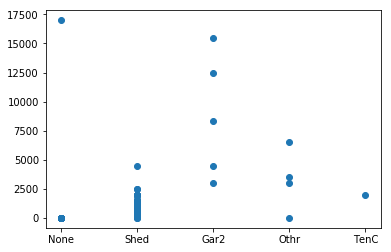

In [74]:
plt.scatter(df['MiscFeature'],df['MiscVal'])

We should first inspect why does the _MiscVal_ has such high right asymmetry. By documentation, it represents the value in dollars of the property's feature given in column _MiscFeature_. Entry that has none additional features should also have it's value zero. The right skew comes form very high prices of second garages. Again, we will skip transforming _YearRemodAdd_ as it is more symmetric without it. 

In [75]:
df.loc[df[(df['MiscFeature']=='None') & (df['MiscVal']>0)].index, 'MiscVal'] = 0

In [76]:
for column in crkoth.drop(['YearRemodAdd', 'LandSlope', 'LandContour']).index:
    transform = np.asarray(df[[column]].values+1)
    trn = sp.stats.boxcox(transform)[0]
    df[column]=trn

In [77]:
uncrookedo = pd.Series(df[other].apply(lambda x: sp.stats.skew(x.dropna())).sort_values(ascending=False))
uncrookedo

MiscVal         5.137003
BsmtHalfBath    3.710100
Fence           1.539367
HalfBath        0.535654
BsmtFullBath    0.360259
HouseStyle      0.186619
Fireplaces      0.115058
BedroomAbvGr    0.094223
TotRmsAbvGrd   -0.000858
GarageCars     -0.008358
TotalBth       -0.009422
FullBath       -0.029582
BsmtExposure   -0.029986
GarageFinish   -0.059584
YearBuilt      -0.265501
YearRemodAdd   -0.451054
LotShape       -0.604428
GarageYrBlt    -0.675969
KitchenAbvGr   -2.056750
LandContour    -3.443483
LandSlope      -4.970969
dtype: float64



#### Creating dummy variables

Categorical values can be shaped to a vector with n binary values, where n is the number of unique items in the categorical dataset. For example, instead of using integers from 0 to 12 for months, we can assign 12 new columns for each and fill the appropriate month with a 1, leaving others filled with 0. These variables are usually called dummy variables and the process itself One-hot encoding. We will build them for each categorical value from the dataframe. First, we have to cast these columns to _Categorical_ type.

Note that we already manually encoded _CentralAir_, _Street_ and _Alley_ in the section _Casting categories to ordinal values_.

We will work with a DataFrame without target prices. Since _Utilities_ bear no real value to predictions as they all have the same value, let's drop them first:

In [78]:
dfc=df.drop(['SalePrice'], axis=1)
dfc.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,TotPorcharea,Totlivarea,TotalBth
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,27.178798,43.829081,1,0,231.045553,3,AllPub,Inside,...,0.0,0.0,0.0,None,0.0,WD,Normal,6.693167,41.849630,1.944447
2,20,RL,31.733852,45.607041,1,0,231.045553,3,AllPub,FR2,...,0.0,0.0,0.0,None,0.0,WD,Normal,0.000000,41.209024,1.549353
3,60,RL,28.111044,47.910592,1,0,53.089030,3,AllPub,Inside,...,0.0,0.0,0.0,None,0.0,WD,Normal,5.828120,42.801475,1.944447
4,70,RL,25.598394,45.532982,1,0,53.089030,3,AllPub,Corner,...,0.0,0.0,0.0,None,0.0,WD,Abnorml,11.412538,41.854489,1.322642
5,60,RL,32.907562,51.557338,1,0,53.089030,3,AllPub,FR2,...,0.0,0.0,0.0,None,0.0,WD,Normal,7.496504,46.529374,1.944447


In [79]:
dfc=dfc.drop(['Utilities'], axis=1)

All other feature that were not checked for asymmetry are of type _Category_:

In [80]:
catCol=df.drop(crkscl.drop('PoolQC').index, axis=1).drop(crkarea.index, axis=1).drop(crkoth.index, axis=1).drop(['CentralAir', 'Street', 'Alley', 'Utilities', 'SalePrice'], axis=1).columns

In [81]:
for columnname in catCol:
    dfc[columnname] = pd.Categorical(dfc[columnname])
dfdummy = pd.get_dummies(dfc)
dfc=pd.concat([dfc, dfdummy], axis=1, sort=False)

In [82]:
dfc.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [83]:
dfc.drop(dfc.select_dtypes(include=['category']).columns, axis=1, inplace=True)

There are no _object_ type columns left.

In [84]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2906 entries, 1 to 2919
Columns: 281 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(102), int64(16), uint8(163)
memory usage: 3.2 MB


Now, we have attributes ready to use in predictions (_Id_ column is not used). Since one-hot encoding and our transformations all give numerical values, types of columns should be either _float_ or _int_. All encoded categories are dropped.

In [85]:
dfc.head()

,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LandSlope,HouseStyle,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,27.178798,43.829081,1,0,231.045553,3,3,0.997883,5.021231,2.983049,...,0,0,0,1,0,0,0,0,1,0
2,31.733852,45.607041,1,0,231.045553,3,3,0.557996,4.414547,4.146873,...,0,0,0,1,0,0,0,0,1,0
3,28.111044,47.910592,1,0,53.089030,3,3,0.997883,5.021231,2.983049,...,0,0,0,1,0,0,0,0,1,0
4,25.598394,45.532982,1,0,53.089030,3,3,0.997883,5.021231,2.983049,...,0,0,0,1,1,0,0,0,0,0
5,32.907562,51.557338,1,0,53.089030,3,3,0.997883,5.609331,2.983049,...,0,0,0,1,0,0,0,0,1,0


13 entries have been deleted as outliers and new columns have been added either as dummy variables or as new attributes. The DataFrame is now ready for train-test split.

In [86]:
trainset=dfc[dfc.index<1461]
testset=dfc[dfc.index>1460]

In [87]:
trainset=trainset.loc[:,~trainset.columns.duplicated()]

In [88]:
testset=testset.loc[:,~testset.columns.duplicated()]

In [89]:
target=df.loc[trainset.index]['SalePrice']

## Models

In [90]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from functools import reduce

Since choosing parameters for our models based on it's score can be a slow task, and there still may be outliers that can affect them negatively, we will preprocess data with a _RobustScaler_ and cross-validate it on 20 splits with K-folding.

In [91]:
kf = KFold(n_splits=20)

Another way of finding outliers after model fitting is to find all predicted values that are outside a range (as distribution width) determined by our sigma. Lowering down the sigma we can choose to penalize more outliers. 

In [92]:
def fndoutlie(prediction, target, sigma):
    error = target - prediction
    errmn = error.mean()
    errstd = error.std()
    a = (error - errmn) / errstd
    a = np.array(a)
    outliers = np.where(abs(a) > abs(a).std() * sigma)[0]
    return outliers

In [93]:
def plotOutlie(model, sigma, trainset, target):
    outlie=fndoutlie(model.predict(trainset), target, sigma)
    plt.scatter(target, model.predict(trainset))
    plt.scatter(target.iloc[outlie], model.predict(trainset)[outlie])
    return outlie

Let's look at the models we are going to use. Later some may be dropped if they do not produce good results. Linear regression, Lasso regression, Kernel ridge and Ridge, and Elastic Net are linear models that require specifying an Alpha value. In Ridge models, this represents regularization strength and in regressions a multiplicative constant. Starting with the simple Linear Regression:

In [94]:
lin = LinearRegression()
linfit=lin.fit(trainset, target)
lin.score(trainset, target)

0.9442523456874204

On this example, we choose to mark a lot of entries as outliers, using sigma as low as 2. We won't be using all of these outliers, as they will highly differ among models. We can also visualize these outliers using the _plotOutlie_ function. Indexes of these outliers are now contained in an appropriate array _linOut_:

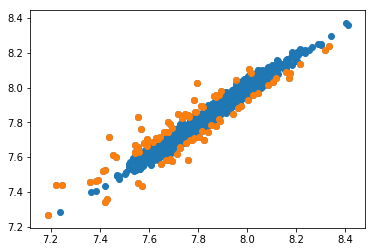

In [95]:
linOut=plotOutlie(lin, 2.5, trainset, target)

For Lasso, too small alpha showed problems with convergence. Still, manually inputing different values showed best scores using around 0.0001. We will try several values around it.  

In [96]:
lsr = make_pipeline(RobustScaler(), LassoCV(max_iter=5000, alphas=[0.00005, 0.00008, 0.0001, 0.00015, 0.00018, 0.0002], cv=kf))
np.sqrt(-cross_val_score(lsr, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

0.04310687600876277

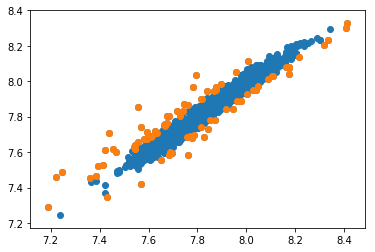

In [97]:
lsrfit=lsr.fit(trainset, target)
lsrOut=plotOutlie(lsr, 2.5, trainset, target)

Since the predicted and real values don't follow neatly a linear trend we will also penalize Lasso with a low sigma of 2. 

As we said, with Ridge alpha denotes regularization strength. Manual input showed a low mean squared error around the value of 16:

In [98]:
rr = make_pipeline(RobustScaler(), RidgeCV(alphas=[14, 15, 15.2, 15.4, 15.6, 15.8, 16, 16.2, 16.4, 16.6, 16.8, 17, 18], cv=kf))
rrfit=rr.fit(trainset, target)
np.sqrt(-cross_val_score(rr, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

0.04331051148652774

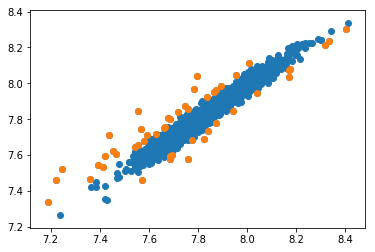

In [99]:
rrOut=plotOutlie(rr, 3, trainset, target)

We can introduce and kernels:

In [100]:
krr = KernelRidge(alpha=0.04)
krrfit=krr.fit(trainset, target)
np.sqrt(-cross_val_score(krr, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

0.05380557054572234

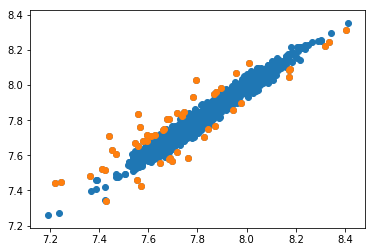

In [101]:
krrOut=plotOutlie(krr, 3, trainset, target)

ElasticNet also shows good results with very low alpha. We can use the same values as Lasso. Due to mentioned Convergence problems, python will return errors when trying to fit with low values. The model still produces good results. 

In [102]:
eln = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=5000, alphas=[0.00005, 0.00008, 0.0001, 0.00015, 0.00018, 0.0002], cv=kf))
elnfit=eln.fit(trainset, target)
np.sqrt(-cross_val_score(eln, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

0.043175160915251365

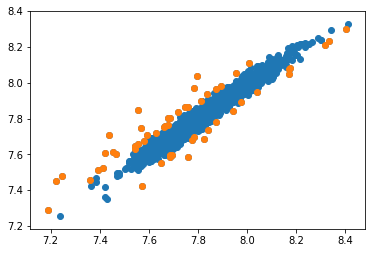

In [103]:
elnOut=plotOutlie(eln, 3, trainset, target)

After linear models, we will also use Trees and their ensembles in prediction. For badly performing models we save more outliers. The trees are based on _mse_, lowering the mean squared error, as well as it is in the task generally. 

Note that these models require longer time for fitting:

In [104]:
rfr = RandomForestRegressor(criterion='mse', n_estimators=400)
rfrfit=rfr.fit(trainset, target)
np.sqrt(-cross_val_score(rfr, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

0.051867402256951856

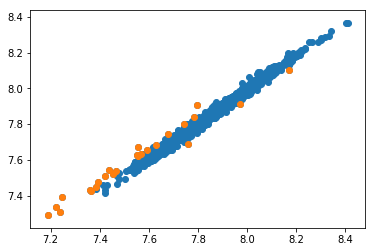

In [105]:
rfrOut=plotOutlie(rfr, 4, trainset, target)

In [106]:
gbr = GradientBoostingRegressor(n_estimators=400)
gbrfit=gbr.fit(trainset, target)
np.sqrt(-cross_val_score(gbr, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

0.04666000721729688

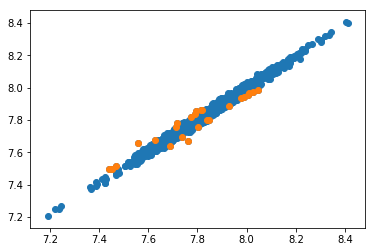

In [107]:
gbrOut=plotOutlie(gbr, 4, trainset, target)

In [108]:
xgb = XGBRegressor(n_estimators=3460, max_depth=6, reg_alpha=0.00001)
xgbfit=xgb.fit(trainset, target)
np.sqrt(-cross_val_score(xgb, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[03:59:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:59:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:59:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:00:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:00:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:00:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:00:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:01:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:01:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:01:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:02:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:02:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:02:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:03:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:03:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:03:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:04:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:04:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:05:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:05:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:06:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.047177029899431885

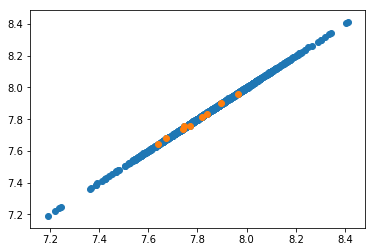

In [109]:
xgbOut=plotOutlie(xgb, 5, trainset, target)

In [110]:
dtr = DecisionTreeRegressor(criterion='mse', max_depth=6)
dtr.fit(trainset, target)
np.sqrt(-cross_val_score(dtr, trainset, target, cv=kf, scoring="neg_mean_squared_error")).mean()

0.07327012588598018

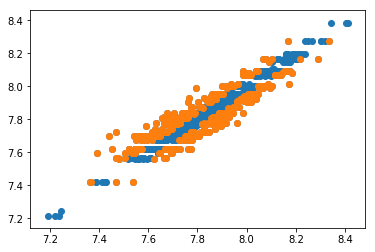

In [111]:
dtrOut=plotOutlie(dtr, 1.5, trainset, target)

We can see that the DecisionTreeRegressor is not fit for this kind of problem. DecisionTreeRegressor and GradientBoostingRegressor perform very well and we will not mark many outliers. We can look at how different models performed by their score:

In [112]:
print('Lasso score: {}'.format(lsr.score(trainset,target)))
print('Ridge score: {}'.format(rr.score(trainset,target)))
print('KernelRidge score: {}'.format(krr.score(trainset,target)))
print('ElasticNet score: {}'.format(eln.score(trainset,target)))
print('RandomForestRegressor score: {}'.format(rfr.score(trainset,target)))
print('GradientBoostingRegressor score: {}'.format(gbr.score(trainset,target)))
print('DecisionTreeRegressor score: {}'.format(dtr.score(trainset,target)))
print('XGBRegressor score: {}'.format(xgb.score(trainset,target)))

Lasso score: 0.936859304034091
Ridge score: 0.9375253465886876
KernelRidge score: 0.9416867897382082
ElasticNet score: 0.9386007961229348
RandomForestRegressor score: 0.9851219395545933
GradientBoostingRegressor score: 0.9883344896797555
DecisionTreeRegressor score: 0.9041210367964745
XGBRegressor score: 0.9999103607621771


XGBoosting is a boosted trees algorithms with very high model performance. It is robust on outliers and performes well on different types of problems. It gives a high score for this problem aswell. 

Let's look at given outliers. Fidderent models gave different entries, and we used different sigma based on model performance. Checking what entries were marked with all models:

In [114]:
linoutlie=reduce(np.intersect1d, (linOut, lsrOut, rrOut, krrOut, elnOut))
regoutlie=reduce(np.intersect1d, (rfrOut, gbrOut, xgbOut))
alloutlie=np.intersect1d(linoutlie, regoutlie)

In [115]:
print('Outliers from linear models:{}'.format(linoutlie))
print('Outliers from other models:{}'.format(regoutlie))
print('Common outliers:{}'.format(alloutlie))

Outliers from linear models:[  30   66   88  107  142  306  324  404  425  456  552  573  580  624
  650  673  680  701  705  717  719  729  763  765  794  800  864  888
  957  959 1011 1051 1111 1170 1201 1310 1312 1367 1370 1419 1440]
Outliers from other models:[]
Common outliers:[]


We can see that only linear models perform badly on common outliers. Other models also produced some values that are far from optimal prediction, but these values don't appear in all of them. Since we will be using linear models in prediction it is better to drop these entries as to not to disform the prediction. 

In [116]:
outlie=linoutlie

In [117]:
newtrainset=trainset.drop(trainset.iloc[outlie].index)

In [118]:
newtarget=target.drop(target.iloc[outlie].index)

## Lasso again

Now that we got rid of outliers, we should run the fitting again. 

In [119]:
linfit2=lin.fit(newtrainset, newtarget)
lsrfit2=lsr.fit(newtrainset, newtarget)
rrfit2=rr.fit(newtrainset, newtarget)
krrfit2=krr.fit(newtrainset, newtarget)
elnfit2=eln.fit(newtrainset, newtarget)
rfrfit2=rfr.fit(newtrainset, newtarget)
gbrfit2=gbr.fit(newtrainset, newtarget)
xgbfit2=xgb.fit(newtrainset, newtarget)

C:\Users\Bubo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[04:06:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [120]:
print('Linear score: {}'.format(lin.score(newtrainset,newtarget)))
print('Lasso score: {}'.format(lsr.score(newtrainset,newtarget)))
print('Ridge score: {}'.format(rr.score(newtrainset,newtarget)))
print('KernelRidge score: {}'.format(krr.score(newtrainset,newtarget)))
print('ElasticNet score: {}'.format(eln.score(newtrainset,newtarget)))
print('RandomForestRegressor score: {}'.format(rfr.score(newtrainset,newtarget)))
print('GradientBoostingRegressor score: {}'.format(gbr.score(newtrainset,newtarget)))
print('XGBRegressor score: {}'.format(xgb.score(newtrainset,newtarget)))

Linear score: 0.965364399754426
Lasso score: 0.9599689230741856
Ridge score: 0.9592880411315897
KernelRidge score: 0.9626678332388465
ElasticNet score: 0.9602658833484121
RandomForestRegressor score: 0.9882415371798203
GradientBoostingRegressor score: 0.9904019825242918
XGBRegressor score: 0.9999018498079235


After dropping the outliers, the models have a slightly better performance.

Since some models perform better on some parts of data, their collective prediction will show best results. Finally, we will make predictions on the testing set and save these as a csv file ready for submission.

In [121]:
predtrain=(0.3*xgb.predict(trainset))+(0.3*gbr.predict(trainset))+(0.1*rfr.predict(trainset))+(0.1*lin.predict(trainset))+(0.1*eln.predict(trainset))+(0.1*krr.predict(trainset))
plt.scatter(predtrain, target)

The previous visualization shows the performance of this prediction blend on our training set. The prediction we are interested in are on the _testset_. We should find the optimal proportion of models in our final prediction. By scoring, it shows to be:

In [173]:
newpredsub=(0.1*xgb.predict(testset))+(0.1*gbr.predict(testset))+(0.2*lin.predict(testset))+(0.2*eln.predict(testset))+(0.2*krr.predict(testset))+(0.2*rr.predict(testset))

Since we transformed our _SalePrice_ column to be more appropriate for models, our predictions are now also in the transformed format. To transform it back to appropriate format of price, we build an inverse Box-cox transformation function, that uses the given _lambda_ used at the beginning:

In [175]:
def ibxcx(x, lmbd):
    r = np.power((x * lmbd) + 1, 1 / lmbd) - 1
    return r

In [176]:
newpredsub_trn=ibxcx(newpredsub,lmbd)

These values are now stored in a DataFrame containing predicted prices with their respective Ids. Finally, we save it as a csv file and this represents our final result:

In [177]:
dfres = pd.DataFrame(newpredsub_trn)
dfres.columns=['SalePrice']
dfres['Id']=dftest.index
dfres.set_index('Id', inplace=True)

In [178]:
dfres.to_csv("submission.csv", index=True)